In [5]:
import networkx as nx
import matplotlib.pyplot as plt
from geopy.distance import geodesic

# Sample points data (replace with your actual data)
points = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {"indoor": True},
            "geometry": {
                "coordinates": [
                    [-113.52122913673706, 53.52501394756737],
                    [-113.52072060360172, 53.52501714929542],
                    [-113.52076956461727, 53.52749981891861],
                    [-113.52245999968656, 53.52748874336393],
                    [-113.52250118998037, 53.52774166970113],
                    [-113.52180141396458, 53.52776674936845],
                    [-113.52144016207536, 53.52819492073496],
                    [-113.52366013697306, 53.52500376534286],
                    [-113.52348994765711, 53.52545758339812],
                    [-113.52420143423929, 53.52524104516334],
                    [-113.52473891745484, 53.52524724666702],
                    [-113.52471219465674, 53.52556226497205],
                    [-113.524719215875, 53.52602161305447],
                    [-113.5240203595364, 53.52601851366529],
                    [-113.52348938972247, 53.52605431729208],
                    [-113.52472183316128, 53.526019256057026],
                    [-113.52474825039536, 53.52649921160733],
                    [-113.52477352830454, 53.527243381822984],
                    [-113.52482665299999, 53.528064289535536],
                    [-113.52484022744565, 53.528231300655534],
                    [-113.52562016493502, 53.52819435619119],
                    [-113.52996818972387, 53.527373472361944],
                    [-113.52954492268842, 53.527095295044774],
                    [-113.52922538969224, 53.526702212783846],
                    [-113.52927240527652, 53.52635337477486],
                    [-113.5293247013037, 53.52597989301563],
                    [-113.5277973268176, 53.52606598703818],
                    [-113.52783785722002, 53.52558920720156]
                ],
                "type": "LineString"
            }
        }
    ]
}

start_coords = (53.52487308195197, -113.52223873635987)  # Replace with your start coordinates
end_coords = (53.528204362561894, -113.52135165224719)  # Replace with your end coordinates
def required_points(start_coords, end_coords):
  # Create a directed or undirected graph
  G = nx.Graph()

  # Add nodes and edges from points data
  for feature in points['features']:
      coords = feature['geometry']['coordinates']
      indoor = feature['properties'].get('indoor', False)
      for i in range(len(coords) - 1):
          pos_A = (coords[i][1], coords[i][0])
          pos_B = (coords[i + 1][1], coords[i + 1][0])
          G.add_node(f'Node_{i}', pos=pos_A)
          G.add_node(f'Node_{i + 1}', pos=pos_B)
          distance = geodesic(pos_A, pos_B).meters
          weight = distance if indoor else distance * 1.5  # Prioritize indoor paths
          G.add_edge(f'Node_{i}', f'Node_{i + 1}', weight=weight, indoor=indoor)

  # Extract positions
  pos = nx.get_node_attributes(G, 'pos')

  def find_nearest_node(graph, lat, lon):
      min_dist = float('inf')
      nearest_node = None
      for node, (node_lat, node_lon) in pos.items():
          dist = geodesic((lat, lon), (node_lat, node_lon)).meters
          if dist < min_dist:
              min_dist = dist
              nearest_node = node
      return nearest_node

  # Specify custom start and end coordinates


  # Find the nearest nodes in the graph to the specified coordinates
  start_node = find_nearest_node(G, *start_coords)
  end_node = find_nearest_node(G, *end_coords)

  # Add start and end points as nodes
  G.add_node('start', pos=start_coords)
  G.add_node('end', pos=end_coords)

  # Ensure the positions of the start and end nodes are included in the pos dictionary
  pos['start'] = start_coords
  pos['end'] = end_coords

  # Connect start and end points to their nearest nodes
  start_distance = geodesic(start_coords, pos[start_node]).meters
  end_distance = geodesic(end_coords, pos[end_node]).meters
  G.add_edge('start', start_node, weight=start_distance)
  G.add_edge('end', end_node, weight=end_distance)

  # Find the shortest path
  shortest_path = nx.shortest_path(G, source='start', target='end', weight='weight')

  # Extract the coordinates of the shortest path
  path_coords = [pos[node] for node in shortest_path]

  # Print the coordinates along the path
  return path_coords

  # # Draw the graph
  # plt.figure(figsize=(10, 8))
  # nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=10, font_weight='bold')
  # nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f'{d["weight"]:.2f}m' for u, v, d in G.edges(data=True)})

  # # Highlight the shortest path
  # path_edges = list(zip(shortest_path, shortest_path[1:]))
  # nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='r', width=2)

  # # Show the plot
  # plt.title('Graph Visualization with Shortest Path')
  # plt.xlabel('Longitude')
  # plt.ylabel('Latitude')
  # plt.grid(True)
  # plt.show()

print(required_points(start_coords, end_coords))


[(53.52487308195197, -113.52223873635987), (53.52501394756737, -113.52122913673706), (53.52501714929542, -113.52072060360172), (53.52749981891861, -113.52076956461727), (53.52748874336393, -113.52245999968656), (53.52774166970113, -113.52250118998037), (53.52776674936845, -113.52180141396458), (53.52819492073496, -113.52144016207536), (53.528204362561894, -113.52135165224719)]


In [63]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import networkx as nx
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import osmnx as ox

# Define start and end coordinates (latitude, longitude)
start_coords = (53.52501394756737, -113.52122913673706)
end_coords = (53.52819492073496, -113.52144016207536)

# Sample points for the pedway (replace with actual data)
points = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {"indoor": True},
            "geometry": {
                "coordinates": [
                    [-113.52122913673706, 53.52501394756737],
                    [-113.52072060360172, 53.52501714929542],
                    [-113.52076956461727, 53.52749981891861],
                    [-113.52245999968656, 53.52748874336393],
                    [-113.52250118998037, 53.52774166970113],
                    [-113.52180141396458, 53.52776674936845],
                    [-113.52144016207536, 53.52819492073496],
                ],
                "type": "LineString"
            }
        }
    ]
}

# Create the road network graph from OSM data
G_road = ox.graph_from_point(start_coords, dist=500, network_type='walk', simplify=True)

# Project the road graph for accurate distance calculations
G_road = ox.project_graph(G_road)
G_road_undirected = G_road.to_undirected()

# Create the pedway network as an undirected MultiGraph
G_pedway = nx.MultiGraph()
for feature in points['features']:
    coords = feature['geometry']['coordinates']
    indoor = feature['properties'].get('indoor', False)
    for i in range(len(coords) - 1):
        lon_A, lat_A = coords[i]
        lon_B, lat_B = coords[i + 1]
        pos_A = (lat_A, lon_A)  # Ensure (latitude, longitude)
        pos_B = (lat_B, lon_B)
        G_pedway.add_node(f'Node_{i}', pos=pos_A)
        G_pedway.add_node(f'Node_{i + 1}', pos=pos_B)
        distance = geodesic(pos_A, pos_B).meters
        weight = distance if indoor else distance * 1.5
        G_pedway.add_edge(f'Node_{i}', f'Node_{i + 1}', weight=weight, indoor=indoor)

# Define function to find the nearest node
def find_nearest_node(G, lat, lon):
    pos = nx.get_node_attributes(G, 'pos')
    min_dist = float('inf')
    nearest_node = None
    for node, (node_lat, node_lon) in pos.items():
        dist = geodesic((lat, lon), (node_lat, node_lon)).meters
        if dist < min_dist:
            min_dist = dist
            nearest_node = node
    return nearest_node

# Find the nearest road nodes to the start and end coordinates
nearest_road_node_start = ox.distance.nearest_nodes(G_road, start_coords[1], start_coords[0])
nearest_road_node_end = ox.distance.nearest_nodes(G_road, end_coords[1], end_coords[0])

# Find the nearest pedway nodes to the start and end coordinates
nearest_pedway_node_start = find_nearest_node(G_pedway, *start_coords)
nearest_pedway_node_end = find_nearest_node(G_pedway, *end_coords)

# Debugging output
print(f"Start coordinates: {start_coords}")
print(f"End coordinates: {end_coords}")
print(f"Nearest road node to start: {nearest_road_node_start}")
print(f"Nearest road node to end: {nearest_road_node_end}")
print(f"Nearest pedway node to start: {nearest_pedway_node_start}")
print(f"Nearest pedway node to end: {nearest_pedway_node_end}")

# Check road graph nodes and positions
print("Road graph nodes and positions:")
for node in G_road_undirected.nodes(data=True):
    print(node)

# Check pedway graph nodes and positions
print("Pedway graph nodes and positions:")
for node in G_pedway.nodes(data=True):
    print(node)

# Combine the road and pedway graphs
G_combined = nx.compose(G_road_undirected, G_pedway)

# Add start and end nodes to the combined graph
G_combined.add_node('start', pos=start_coords)
G_combined.add_node('end', pos=end_coords)

# Ensure the nearest road nodes are added
if nearest_road_node_start in G_road_undirected.nodes:
    G_combined.add_edge('start', nearest_road_node_start, weight=geodesic(start_coords, nx.get_node_attributes(G_road_undirected, 'pos')[nearest_road_node_start]).meters)
else:
    print("Error: Nearest road node not found in the combined graph.")

if nearest_road_node_end in G_road_undirected.nodes:
    G_combined.add_edge('end', nearest_road_node_end, weight=geodesic(end_coords, nx.get_node_attributes(G_road_undirected, 'pos')[nearest_road_node_end]).meters)
else:
    print("Error: Nearest road node not found in the combined graph.")

# Debugging output: print all nodes and edges in the combined graph
print("Nodes in combined graph:")
print(G_combined.nodes(data=True))
print("Edges in combined graph:")
print(G_combined.edges(data=True))

# Find the shortest path in the combined graph
try:
    shortest_path = nx.shortest_path(G_combined, source='start', target='end', weight='weight')
    # Debugging output
    print(f"Shortest path: {shortest_path}")
except nx.NetworkXNoPath:
    print("No path found between start and end nodes.")

# Plot the combined graph with the shortest path
pos = nx.get_node_attributes(G_combined, 'pos')
plt.figure(figsize=(10, 8))
nx.draw(G_combined, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=10, font_weight='bold')
if 'shortest_path' in locals():
    path_edges = list(zip(shortest_path, shortest_path[1:]))
    nx.draw_networkx_edges(G_combined, pos, edgelist=path_edges, edge_color='r', width=2)
plt.title('Shortest Path on Combined Road and Pedway Network')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()


Start coordinates: (53.52501394756737, -113.52122913673706)
End coordinates: (53.52819492073496, -113.52144016207536)
Nearest road node to start: 3758465398
Nearest road node to end: 3758465398
Nearest pedway node to start: Node_0
Nearest pedway node to end: Node_6
Road graph nodes and positions:
(236637858, {'y': 5933601.4595710905, 'x': 333100.2707223282, 'street_count': 3, 'lon': -113.5178136, 'lat': 53.5247916})
(4317849821, {'y': 5933599.259549457, 'x': 333167.8580938989, 'street_count': 3, 'lon': -113.5167939, 'lat': 53.5247933})
(7692579963, {'y': 5933608.634208069, 'x': 333100.4978667482, 'street_count': 4, 'highway': 'crossing', 'lon': -113.517814, 'lat': 53.5248561})
(6501277639, {'y': 5933595.583992874, 'x': 333099.837351057, 'street_count': 3, 'highway': 'crossing', 'lon': -113.517817, 'lat': 53.5247387})
(246705249, {'y': 5933409.852189389, 'x': 332578.0172445429, 'street_count': 4, 'highway': 'traffic_signals', 'lon': -113.5255814, 'lat': 53.5229049})
(8605254715, {'y': 5

KeyError: 3758465398

Start coordinates: (53.52501394756737, -113.52122913673706)
End coordinates: (53.52819492073496, -113.52144016207536)
Nearest road node to start: 3758465398
Nearest road node to end: 3758465398
Nearest pedway node to start: Node_0
Nearest pedway node to end: Node_6
Error: Nearest road node not found in the combined graph.
Error: Nearest road node not found in the combined graph.
Nodes in combined graph:
[(236637858, {'y': 5933601.4595710905, 'x': 333100.2707223282, 'street_count': 3, 'lon': -113.5178136, 'lat': 53.5247916}), (4317849821, {'y': 5933599.259549457, 'x': 333167.8580938989, 'street_count': 3, 'lon': -113.5167939, 'lat': 53.5247933}), (7692579963, {'y': 5933608.634208069, 'x': 333100.4978667482, 'street_count': 4, 'highway': 'crossing', 'lon': -113.517814, 'lat': 53.5248561}), (6501277639, {'y': 5933595.583992874, 'x': 333099.837351057, 'street_count': 3, 'highway': 'crossing', 'lon': -113.517817, 'lat': 53.5247387}), (246705249, {'y': 5933409.852189389, 'x': 332578.01724454

NetworkXError: Node 236637858 has no position.

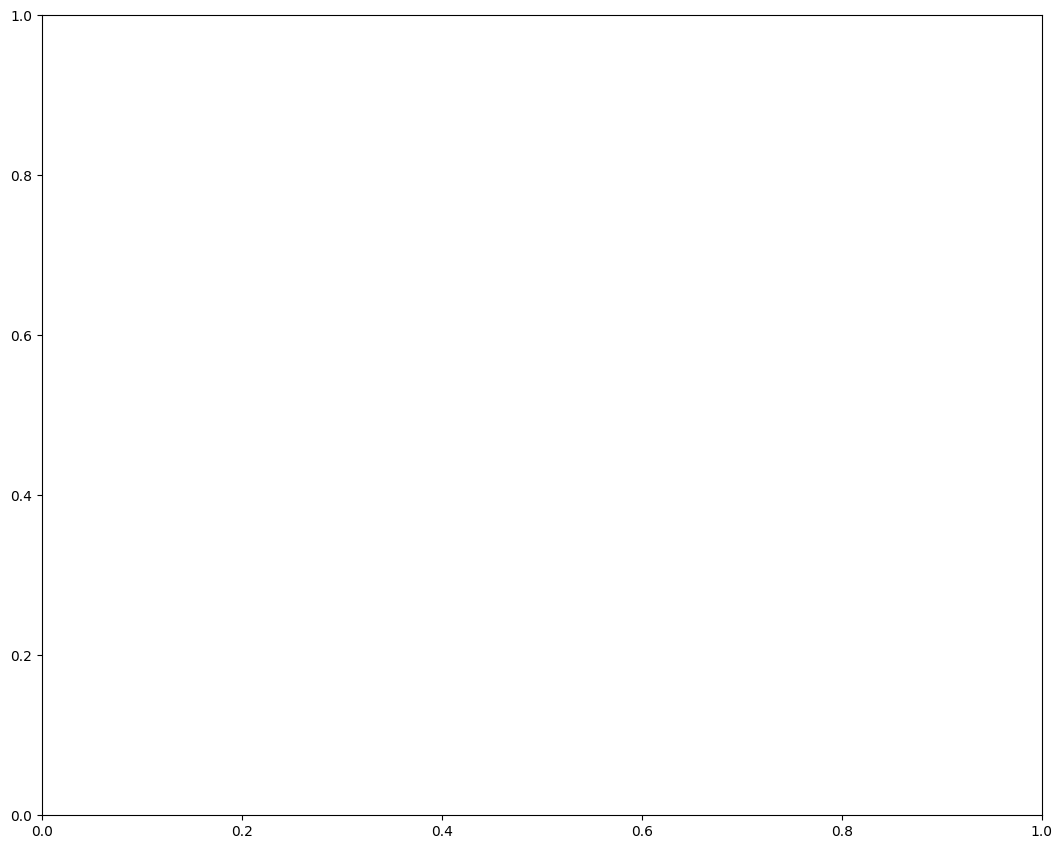

In [69]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import networkx as nx
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import osmnx as ox

# Define start and end coordinates (latitude, longitude)
start_coords = (53.52501394756737, -113.52122913673706)
end_coords = (53.52819492073496, -113.52144016207536)

# Sample points for the pedway (replace with actual data)
points = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {"indoor": True},
            "geometry": {
                "coordinates": [
                    [-113.52122913673706, 53.52501394756737],
                    [-113.52072060360172, 53.52501714929542],
                    [-113.52076956461727, 53.52749981891861],
                    [-113.52245999968656, 53.52748874336393],
                    [-113.52250118998037, 53.52774166970113],
                    [-113.52180141396458, 53.52776674936845],
                    [-113.52144016207536, 53.52819492073496],
                ],
                "type": "LineString"
            }
        }
    ]
}

# Create the road network graph from OSM data
G_road = ox.graph_from_point(start_coords, dist=500, network_type='walk', simplify=True)

# Project the road graph for accurate distance calculations
G_road = ox.project_graph(G_road)
G_road_undirected = G_road.to_undirected()

# Create the pedway network as an undirected MultiGraph
G_pedway = nx.MultiGraph()
for feature in points['features']:
    coords = feature['geometry']['coordinates']
    indoor = feature['properties'].get('indoor', False)
    for i in range(len(coords) - 1):
        lon_A, lat_A = coords[i]
        lon_B, lat_B = coords[i + 1]
        pos_A = (lat_A, lon_A)  # Ensure (latitude, longitude)
        pos_B = (lat_B, lon_B)
        G_pedway.add_node(f'Node_{i}', pos=pos_A)
        G_pedway.add_node(f'Node_{i + 1}', pos=pos_B)
        distance = geodesic(pos_A, pos_B).meters
        weight = distance if indoor else distance * 1.5
        G_pedway.add_edge(f'Node_{i}', f'Node_{i + 1}', weight=weight, indoor=indoor)

# Define function to find the nearest node
def find_nearest_node(G, lat, lon):
    pos = nx.get_node_attributes(G, 'pos')
    min_dist = float('inf')
    nearest_node = None
    for node, (node_lat, node_lon) in pos.items():
        dist = geodesic((lat, lon), (node_lat, node_lon)).meters
        if dist < min_dist:
            min_dist = dist
            nearest_node = node
    return nearest_node

# Find the nearest road nodes to the start and end coordinates
nearest_road_node_start = ox.distance.nearest_nodes(G_road, start_coords[1], start_coords[0])
nearest_road_node_end = ox.distance.nearest_nodes(G_road, end_coords[1], end_coords[0])

# Find the nearest pedway nodes to the start and end coordinates
nearest_pedway_node_start = find_nearest_node(G_pedway, *start_coords)
nearest_pedway_node_end = find_nearest_node(G_pedway, *end_coords)

# Debugging output
print(f"Start coordinates: {start_coords}")
print(f"End coordinates: {end_coords}")
print(f"Nearest road node to start: {nearest_road_node_start}")
print(f"Nearest road node to end: {nearest_road_node_end}")
print(f"Nearest pedway node to start: {nearest_pedway_node_start}")
print(f"Nearest pedway node to end: {nearest_pedway_node_end}")

# Combine the road and pedway graphs
G_combined = nx.compose(G_road_undirected, G_pedway)

# Ensure the positions of the start and end nodes are included in the pos dictionary
pos = nx.get_node_attributes(G_combined, 'pos')
pos['start'] = start_coords
pos['end'] = end_coords

# Add start and end nodes to the combined graph
G_combined.add_node('start', pos=start_coords)
G_combined.add_node('end', pos=end_coords)

# Add road nodes to the combined graph if they are missing
for node in [nearest_road_node_start, nearest_road_node_end]:
    if node not in G_combined.nodes:
        pos_node = nx.get_node_attributes(G_road_undirected, 'pos').get(node)
        if pos_node:
            G_combined.add_node(node, pos=pos_node)
        else:
            print(f"Warning: Node {node} has no position in G_road_undirected.")

# Connect start and end points to their nearest nodes
if nearest_road_node_start in pos:
    start_distance = geodesic(start_coords, pos.get(nearest_road_node_start, start_coords)).meters
    G_combined.add_edge('start', nearest_road_node_start, weight=start_distance)
else:
    print("Error: Nearest road node not found in the combined graph.")

if nearest_road_node_end in pos:
    end_distance = geodesic(end_coords, pos.get(nearest_road_node_end, end_coords)).meters
    G_combined.add_edge('end', nearest_road_node_end, weight=end_distance)
else:
    print("Error: Nearest road node not found in the combined graph.")

# Debugging output: print all nodes and edges in the combined graph
print("Nodes in combined graph:")
print(G_combined.nodes(data=True))
print("Edges in combined graph:")
print(G_combined.edges(data=True))

# Find the shortest path in the combined graph
try:
    shortest_path = nx.shortest_path(G_combined, source='start', target='end', weight='weight')
    # Debugging output
    print(f"Shortest path: {shortest_path}")
except nx.NetworkXNoPath:
    print("No path found between start and end nodes.")

# Plot the combined graph with the shortest path
pos = nx.get_node_attributes(G_combined, 'pos')
plt.figure(figsize=(10, 8))
nx.draw(G_combined, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=10, font_weight='bold')
if 'shortest_path' in locals():
    path_edges = list(zip(shortest_path, shortest_path[1:]))
    nx.draw_networkx_edges(G_combined, pos, edgelist=path_edges, edge_color='r', width=2)
plt.title('Shortest Path on Combined Road and Pedway Network')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()


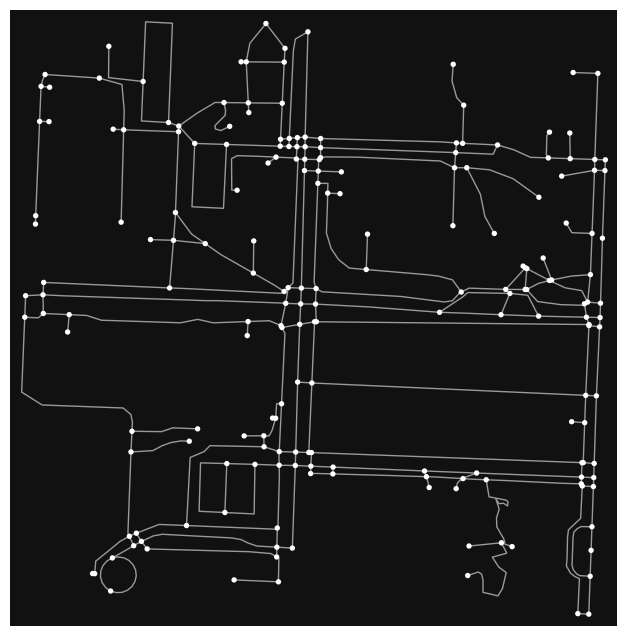

In [92]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import networkx as nx
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import osmnx as ox

# Define start and end coordinates (latitude, longitude)
start_coords = (53.522884193395385, -113.52083568201627)
end_coords = (53.52819492073496, -113.52144016207536)

# Sample points for the pedway (replace with actual data)
points = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {"indoor": True},
            "geometry": {
                "coordinates": [
                    [-113.52122913673706, 53.52501394756737],
                    [-113.52072060360172, 53.52501714929542],
                    [-113.52076956461727, 53.52749981891861],
                    [-113.52245999968656, 53.52748874336393],
                    [-113.52250118998037, 53.52774166970113],
                    [-113.52180141396458, 53.52776674936845],
                    [-113.52144016207536, 53.52819492073496],
                ],
                "type": "LineString"
            }
        }
    ]
}


# Create the road network graph from OSM data
G_road = ox.graph_from_point(start_coords, dist=200, network_type='walk', simplify=True)

# Project the road graph for accurate distance calculations
G_road = ox.project_graph(G_road)
G_road_undirected = G_road.to_undirected()
fig, ax = ox.plot_graph(G_road_undirected)



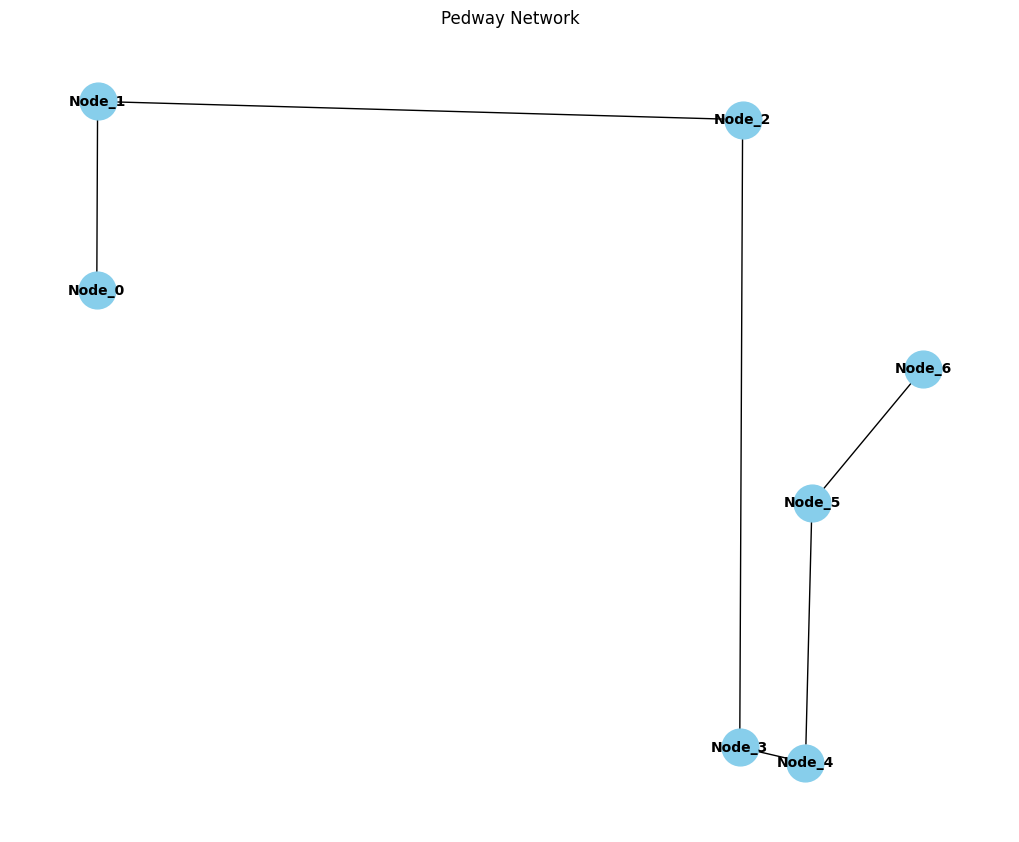

In [93]:
G_pedway = nx.MultiGraph()
for feature in points['features']:
    coords = feature['geometry']['coordinates']
    indoor = feature['properties'].get('indoor', False)
    for i in range(len(coords) - 1):
        lon_A, lat_A = coords[i]
        lon_B, lat_B = coords[i + 1]
        pos_A = (lat_A, lon_A)  # Ensure (latitude, longitude)
        pos_B = (lat_B, lon_B)
        G_pedway.add_node(f'Node_{i}', pos=pos_A)
        G_pedway.add_node(f'Node_{i + 1}', pos=pos_B)
        distance = geodesic(pos_A, pos_B).meters
        weight = distance if indoor else distance * 1.5
        G_pedway.add_edge(f'Node_{i}', f'Node_{i + 1}', weight=weight, indoor=indoor)

        
# Extract the positions of the nodes
pos = nx.get_node_attributes(G_pedway, 'pos')

# Plot the pedway graph
plt.figure(figsize=(10, 8))
nx.draw(G_pedway, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=10, font_weight='bold')
plt.title('Pedway Network')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [94]:
def find_nearest_node(G, lat, lon):
    pos = nx.get_node_attributes(G, 'pos')
    min_dist = float('inf')
    nearest_node = None
    for node, (node_lat, node_lon) in pos.items():
        dist = geodesic((lat, lon), (node_lat, node_lon)).meters
        if dist < min_dist:
            min_dist = dist
            nearest_node = node
    return nearest_node

In [96]:
nearest_pedway_node_start = find_nearest_node(G_pedway, *start_coords)
print(nearest_pedway_node_start)
start_pedway_node_properties = G_pedway.nodes[nearest_pedway_node_start]
print(start_pedway_node_properties)

Node_1
{'pos': (53.52501714929542, -113.52072060360172)}


In [97]:
nearest_road_node_pedway_node = ox.distance.nearest_nodes(G_road, start_pedway_node_properties["pos"][1], start_pedway_node_properties["pos"][0])
print(nearest_road_node_pedway_node)

# Get the properties of the nearest road node
road_end_node_properties = G_road.nodes[nearest_road_node_pedway_node]
print(road_end_node_properties)


654276698
{'y': 5933205.828182223, 'x': 332762.79878782015, 'street_count': 3, 'lon': -113.522688, 'lat': 53.5211316}


In [98]:
print("Start coordinates:", start_coords)
print("Pedway node coordinates:", start_pedway_node_properties["pos"])

Start coordinates: (53.522884193395385, -113.52083568201627)
Pedway node coordinates: (53.52501714929542, -113.52072060360172)


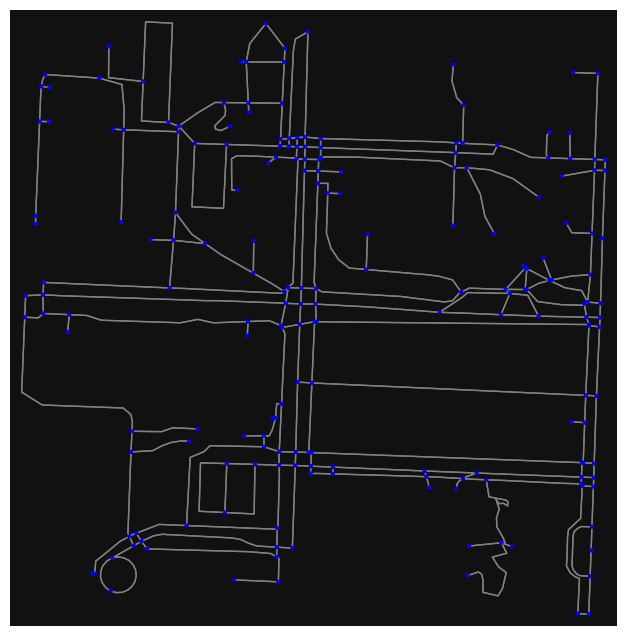

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [99]:
import matplotlib.pyplot as plt
ox.plot_graph(G_road, node_color='blue', node_size=10, edge_color='gray')

In [113]:
import networkx as nx
import osmnx as ox
from geopy.distance import geodesic

# Start and end coordinates
start_coords = (53.526254368319826, -113.52361696744005)

# Find the nearest road node to the start coordinates
nearest_road_node_start = ox.distance.nearest_nodes(G_road, start_coords[1], start_coords[0])
print("Nearest road node to start:", nearest_road_node_start)

# Get the properties of the nearest road node
road_start_node_properties = G_road.nodes[nearest_road_node_start]
print("Road start node properties:", road_start_node_properties)

# Find the nearest pedway node to the start coordinates
nearest_pedway_node_start = find_nearest_node(G_pedway, *start_coords)
print("Nearest pedway node to start:", nearest_pedway_node_start)
start_pedway_node_properties = G_pedway.nodes[nearest_pedway_node_start]
print("Pedway start node properties:", start_pedway_node_properties)

# Check if the pedway node is too close to the start coordinates
pedway_to_start_distance = geodesic(start_coords, start_pedway_node_properties["pos"]).meters
print(f"Distance from start to pedway node: {pedway_to_start_distance:.2f} meters")

# If they are too close, consider this in your logic
if pedway_to_start_distance < 10:  # Adjust this threshold as needed
    print("Pedway node is very close to start coordinates, might overlap with the road node.")
else:
    # Find the nearest road node to the pedway node's position
    nearest_road_node_pedway_node = ox.distance.nearest_nodes(G_road, start_pedway_node_properties["pos"][1], start_pedway_node_properties["pos"][0])
    print("Nearest road node to pedway node:", nearest_road_node_pedway_node)

    # Get the properties of the nearest road node
    road_end_node_properties = G_road.nodes[nearest_road_node_pedway_node]
    print("Road end node properties:", road_end_node_properties)

    # If they are the same, investigate further
    if nearest_road_node_start == nearest_road_node_pedway_node:
        print("Warning: Nearest road node to start and pedway are the same, further investigation needed.")


Nearest road node to start: 654276698
Road start node properties: {'y': 5933205.828182223, 'x': 332762.79878782015, 'street_count': 3, 'lon': -113.522688, 'lat': 53.5211316}
Nearest pedway node to start: Node_3
Pedway start node properties: {'pos': (53.52748874336393, -113.52245999968656)}
Distance from start to pedway node: 157.35 meters
Nearest road node to pedway node: 654276698
Road end node properties: {'y': 5933205.828182223, 'x': 332762.79878782015, 'street_count': 3, 'lon': -113.522688, 'lat': 53.5211316}


Nearest road node to start: 654276698
Road start node properties: {'y': 5933205.828182223, 'x': 332762.79878782015, 'street_count': 3, 'lon': -113.522688, 'lat': 53.5211316}
Nearest pedway node to start: Node_3
Pedway start node properties: {'pos': (53.52748874336393, -113.52245999968656)}
Distance from start to pedway node: 157.35 meters


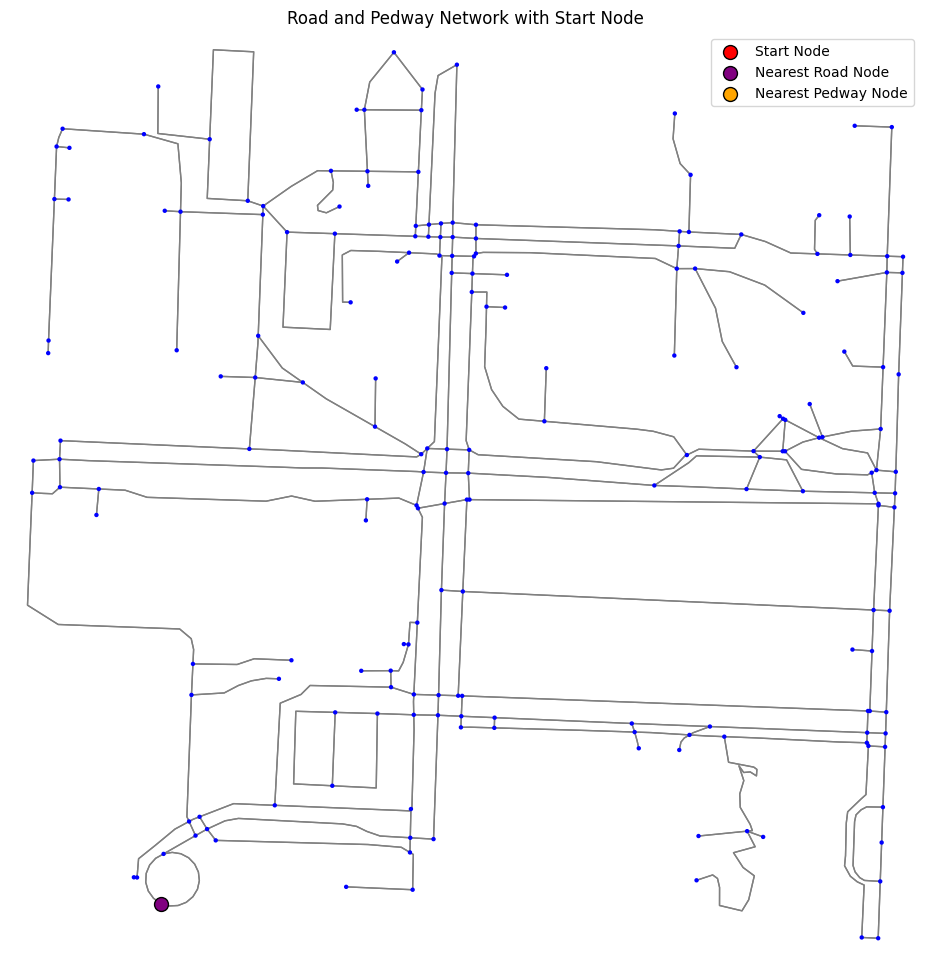

In [116]:
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
from geopy.distance import geodesic

# Start coordinates
start_coords = (53.526254368319826, -113.52361696744005)

# Find the nearest road node to the start coordinates
nearest_road_node_start = ox.distance.nearest_nodes(G_road, start_coords[1], start_coords[0])
print("Nearest road node to start:", nearest_road_node_start)

# Get the properties of the nearest road node
road_start_node_properties = G_road.nodes[nearest_road_node_start]
print("Road start node properties:", road_start_node_properties)

# Find the nearest pedway node to the start coordinates
nearest_pedway_node_start = find_nearest_node(G_pedway, *start_coords)
print("Nearest pedway node to start:", nearest_pedway_node_start)
start_pedway_node_properties = G_pedway.nodes[nearest_pedway_node_start]
print("Pedway start node properties:", start_pedway_node_properties)

# Check the distance from start to pedway node
pedway_to_start_distance = geodesic(start_coords, start_pedway_node_properties["pos"]).meters
print(f"Distance from start to pedway node: {pedway_to_start_distance:.2f} meters")

# Plotting the road network using osmnx
fig, ax = plt.subplots(figsize=(12, 12))
ox.plot_graph(G_road, ax=ax, node_color='blue', node_size=10, edge_color='gray', show=False, close=False)

# Plot the pedway network using networkx
pos = nx.get_node_attributes(G_pedway, 'pos')
nx.draw(G_pedway, pos, ax=ax, with_labels=True, node_size=100, node_color='green', font_size=8, font_weight='bold', edge_color='green')

# Plot the start node
ax.scatter(start_coords[1], start_coords[0], c='red', s=100, label='Start Node', edgecolors='black', zorder=5)

# Plot the nearest road node
road_node_pos = (road_start_node_properties['x'], road_start_node_properties['y'])
ax.scatter(road_node_pos[0], road_node_pos[1], c='purple', s=100, label='Nearest Road Node', edgecolors='black', zorder=5)

# Plot the nearest pedway node
pedway_node_pos = (start_pedway_node_properties['pos'][1], start_pedway_node_properties['pos'][0])
ax.scatter(pedway_node_pos[0], pedway_node_pos[1], c='orange', s=100, label='Nearest Pedway Node', edgecolors='black', zorder=5)

# Display the plot with legend
ax.legend()
plt.title('Road and Pedway Network with Start Node')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()


Nearest road node to start: 7758158774
Road start node properties: {'y': 5933310.186366782, 'x': 332852.6341388355, 'street_count': 1, 'lon': -113.52139, 'lat': 53.5220973}
Nearest pedway node to start: Node_4
Pedway start node properties: {'pos': (53.38104232842126, 668071.3908325832)}
Distance from start to pedway node: 1646479.73 meters


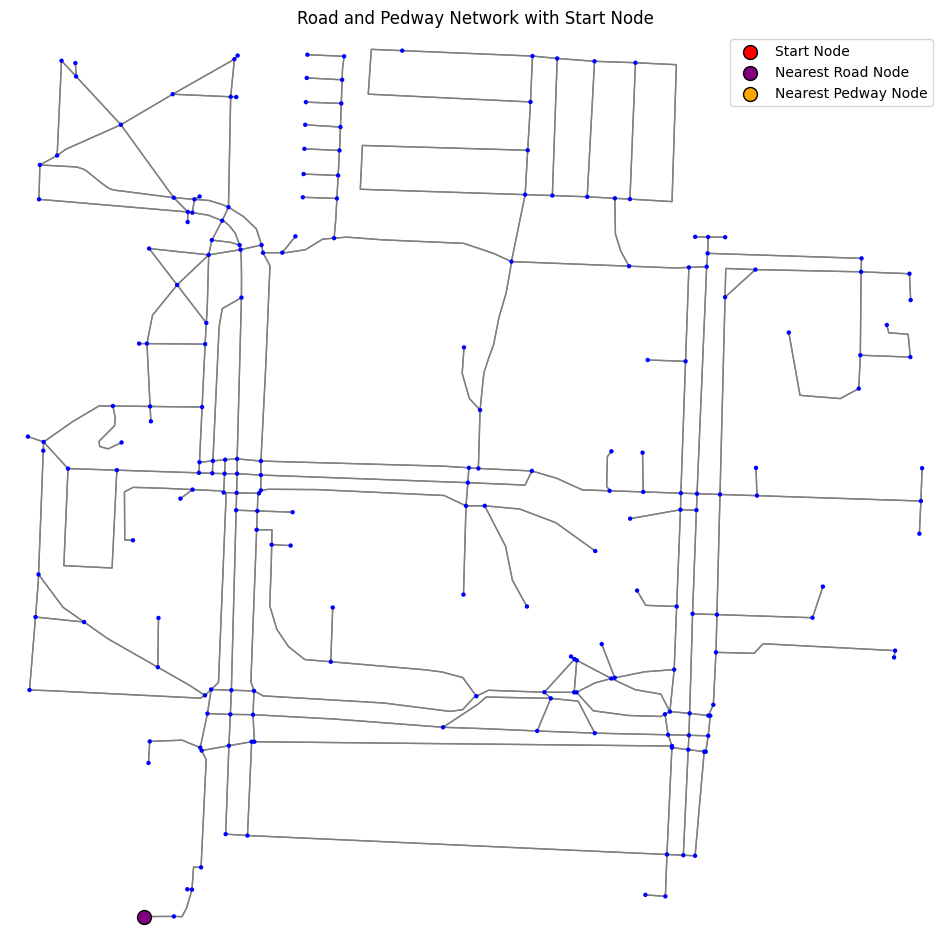

In [121]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import networkx as nx
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import osmnx as ox
from shapely.geometry import Point

# Define start and end coordinates (latitude, longitude)
start_coords = (53.523884102161475, -113.5192962540161)
end_coords = (53.52819492073496, -113.52144016207536)

# Sample points for the pedway (replace with actual data)
points = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {"indoor": True},
            "geometry": {
                "coordinates": [
                    [-113.52122913673706, 53.52501394756737],
                    [-113.52072060360172, 53.52501714929542],
                    [-113.52076956461727, 53.52749981891861],
                    [-113.52245999968656, 53.52748874336393],
                    [-113.52250118998037, 53.52774166970113],
                    [-113.52180141396458, 53.52776674936845],
                    [-113.52144016207536, 53.52819492073496],
                ],
                "type": "LineString"
            }
        }
    ]
}

# Create the road network graph from OSM data
G_road = ox.graph_from_point(start_coords, dist=200, network_type='walk', simplify=True)

# Project the road graph for accurate distance calculations
G_road = ox.project_graph(G_road)

# Initialize the pedway graph
G_pedway = nx.MultiGraph()

# Project pedway points to the same CRS as the road network
crs = G_road.graph['crs']

for feature in points['features']:
    coords = feature['geometry']['coordinates']
    indoor = feature['properties'].get('indoor', False)
    for i in range(len(coords) - 1):
        lon_A, lat_A = coords[i]
        lon_B, lat_B = coords[i + 1]

        # Convert coordinates to shapely Point objects
        point_A = Point(lon_A, lat_A)
        point_B = Point(lon_B, lat_B)

        # Project the points
        point_A_proj = ox.projection.project_geometry(point_A, crs=crs)[0]
        point_B_proj = ox.projection.project_geometry(point_B, crs=crs)[0]

        pos_A = (point_A_proj.y, point_A_proj.x)  # Ensure (latitude, longitude)
        pos_B = (point_B_proj.y, point_B_proj.x)

        # Add nodes and edges to the pedway graph
        G_pedway.add_node(f'Node_{i}', pos=pos_A)
        G_pedway.add_node(f'Node_{i + 1}', pos=pos_B)
        distance = geodesic((lat_A, lon_A), (lat_B, lon_B)).meters
        weight = distance if indoor else distance * 1.5
        G_pedway.add_edge(f'Node_{i}', f'Node_{i + 1}', weight=weight, indoor=indoor)

# Function to find the nearest node in a custom graph
def find_nearest_node(G, lat, lon):
    pos = nx.get_node_attributes(G, 'pos')
    min_dist = float('inf')
    nearest_node = None
    for node, (node_lat, node_lon) in pos.items():
        dist = geodesic((lat, lon), (node_lat, node_lon)).meters
        if dist < min_dist:
            min_dist = dist
            nearest_node = node
    return nearest_node

# Find the nearest road node to the start coordinates
nearest_road_node_start = ox.distance.nearest_nodes(G_road, start_coords[1], start_coords[0])
print("Nearest road node to start:", nearest_road_node_start)

# Get the properties of the nearest road node
road_start_node_properties = G_road.nodes[nearest_road_node_start]
print("Road start node properties:", road_start_node_properties)

# Find the nearest pedway node to the start coordinates
nearest_pedway_node_start = find_nearest_node(G_pedway, *start_coords)
print("Nearest pedway node to start:", nearest_pedway_node_start)
start_pedway_node_properties = G_pedway.nodes[nearest_pedway_node_start]
print("Pedway start node properties:", start_pedway_node_properties)

# Check the distance from start to pedway node
pedway_to_start_distance = geodesic(start_coords, start_pedway_node_properties["pos"]).meters
print(f"Distance from start to pedway node: {pedway_to_start_distance:.2f} meters")

# Plotting the road network using osmnx
fig, ax = plt.subplots(figsize=(12, 12))
ox.plot_graph(G_road, ax=ax, node_color='blue', node_size=10, edge_color='gray', show=False, close=False)

# Plot the pedway network using networkx
pos = nx.get_node_attributes(G_pedway, 'pos')
nx.draw(G_pedway, pos, ax=ax, with_labels=True, node_size=100, node_color='green', font_size=8, font_weight='bold', edge_color='green')

# Plot the start node
ax.scatter(start_coords[1], start_coords[0], c='red', s=100, label='Start Node', edgecolors='black', zorder=5)

# Plot the nearest road node
road_node_pos = (road_start_node_properties['x'], road_start_node_properties['y'])
ax.scatter(road_node_pos[0], road_node_pos[1], c='purple', s=100, label='Nearest Road Node', edgecolors='black', zorder=5)

# Plot the nearest pedway node
pedway_node_pos = start_pedway_node_properties['pos']
ax.scatter(pedway_node_pos[1], pedway_node_pos[0], c='orange', s=100, label='Nearest Pedway Node', edgecolors='black', zorder=5)

# Adjust axis limits to zoom out
ax.set_xlim(ax.get_xlim()[0] - 0.005, ax.get_xlim()[1] + 0.005)
ax.set_ylim(ax.get_ylim()[0] - 0.005, ax.get_ylim()[1] + 0.005)

# Display the plot with legend
ax.legend()
plt.title('Road and Pedway Network with Start Node')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()
